In [22]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import umap
import math
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import pdist, squareform
import time
import heapq

np.random.seed(2024)

In [23]:
def extract_video_data(video_features_path, labels_df):
    video_features = []
    video_labels = []
    video_empty_frames = 0
    
    for each_video in glob.glob(os.path.join(video_features_path, '*.npy')):
        youtube_id = os.path.basename(each_video).split('_')[0]
        current_video_feature = np.load(each_video)

        if current_video_feature.size == 0:
            video_empty_frames += 1
            continue

        
        current_video_feature_avg = np.mean(current_video_feature, axis = 0)
        
        video_features.append(current_video_feature_avg)

        current_video_label = labels_df[labels_df['youtube_id'] == youtube_id]['label'].values[0]
        video_labels.append(current_video_label)

    print(f'Número de videos vacíos no agregados ({video_features_path}): {video_empty_frames}')    
    
    video_features_stacked = np.vstack(video_features)
    video_labels_stacked = np.vstack(video_labels)
    
    df_features = pd.DataFrame(video_features_stacked)
    df_labels = pd.DataFrame(video_labels_stacked)

    return df_features, df_labels



In [24]:
df_train_labels = pd.read_csv('./data/train_subset.csv', header = None, names = ['youtube_id', 'label'])
df_val_labels = pd.read_csv('./data/val_subset.csv', header = None, names = ['youtube_id', 'label'])

X_train, Y_train = extract_video_data('./data/train_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics', df_train_labels)
X_train.dropna(inplace = True)
Y_train.dropna(inplace = True)

print(f'\nNúmero de videos cargados para entrenamiento: {len(X_train)}')
print(f'Shape de nuestra matriz de videos para entrenamiento: {X_train.shape}')

Número de videos vacíos no agregados (./data/train_output/r21d/r2plus1d_34_32_ig65m_ft_kinetics): 15

Número de videos cargados para entrenamiento: 10680
Shape de nuestra matriz de videos para entrenamiento: (10680, 512)


In [30]:
scaler = PowerTransformer(method='yeo-johnson')
normalized_data = scaler.fit_transform(X_train)

In [31]:
le = preprocessing.LabelEncoder()
le.fit(Y_train.to_numpy().ravel())
Y_train_encoded = le.transform(Y_train.to_numpy().ravel())

In [32]:


def get_distance_measure(M):
    if M == 'euclidean':
        return lambda cluster1, cluster2: np.linalg.norm(np.mean(cluster1, axis=0) - np.mean(cluster2, axis=0))
    return None

class AgglomerativeHierarchicalClustering:
    def __init__(self, data, K, M='euclidean'):
        self.data = data
        self.N = len(data)
        self.K = K
        self.measure = get_distance_measure(M)
        self.clusters = self.init_clusters()
        self.heap = self.init_heap()

    def init_clusters(self):
        return {i: [point] for i, point in enumerate(self.data)}

    def init_heap(self):
        dist_matrix = squareform(pdist(self.data, 'euclidean'))
        heap = []
        for i in range(self.N):
            for j in range(i + 1, self.N):
                heapq.heappush(heap, (dist_matrix[i, j], i, j))
        return heap

    def find_closest_clusters(self):
        while self.heap:
            distance, ci_id, cj_id = heapq.heappop(self.heap)
            if ci_id in self.clusters and cj_id in self.clusters:
                return ci_id, cj_id
        return None, None

    def merge_and_form_new_clusters(self, ci_id, cj_id):
        new_cluster_id = min(ci_id, cj_id)
        old_cluster_id = max(ci_id, cj_id)

        self.clusters[new_cluster_id] += self.clusters[old_cluster_id]
        del self.clusters[old_cluster_id]

        new_distances = []
        for cluster_id in self.clusters:
            if cluster_id != new_cluster_id:
                new_distance = self.measure(self.clusters[new_cluster_id], self.clusters[cluster_id])
                heapq.heappush(self.heap, (new_distance, min(new_cluster_id, cluster_id), max(new_cluster_id, cluster_id)))

    def run_algorithm(self):
        while len(self.clusters) > self.K:
            ci_id, cj_id = self.find_closest_clusters()
            if ci_id is None or cj_id is None:
                break
            self.merge_and_form_new_clusters(ci_id, cj_id)

        print(f"Número final de clusters: {len(self.clusters)}")

    def get_cluster_labels(self):
        labels = np.zeros(self.N)
        for cluster_id, points in self.clusters.items():
            for point in points:
                point_idx = np.where(np.all(self.data == point, axis=1))[0][0]
                labels[point_idx] = cluster_id
        
        
        unique_labels = np.unique(labels)
        label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
        labels = np.array([label_mapping[label] for label in labels])
        
        return labels

    def print_clusters(self):
        for cluster_id, points in self.clusters.items():
            print(f"Cluster: {cluster_id}")
            for point in points:
                print(f"    {point}")



Número final de clusters: 20
Tiempo de ejecución de la implementación personalizada en subconjunto: 947.93 segundos
Agglomerative Clustering Personalizado - Silhouette Score: 0.8185, Adjusted Rand Index: 0.9372, Adjusted Mutual Information: 0.9494
Número de clusters en la implementación personalizada: 20
Número de clusters en la implementación con scikit-learn: 20
Agglomerative Clustering con scikit-learn - Silhouette Score: 0.8253, Adjusted Rand Index: 0.9459, Adjusted Mutual Information: 0.9526


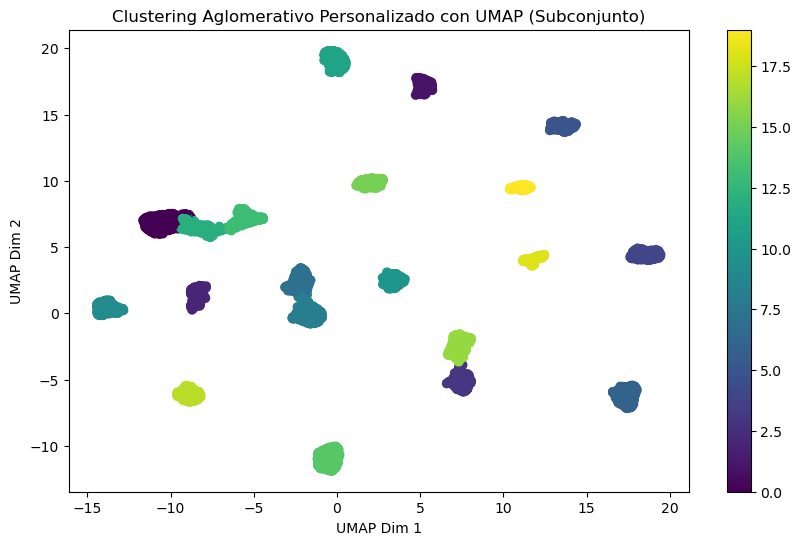

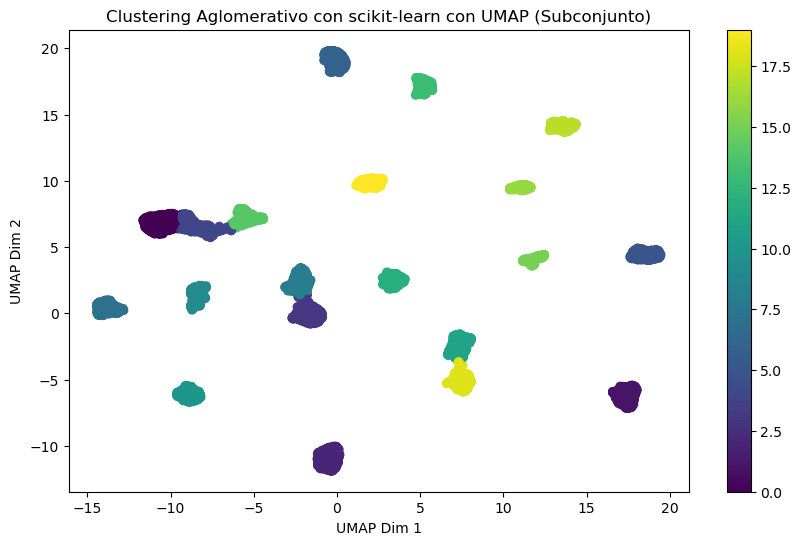

In [34]:
subset_size = 10000

X_train_subset = normalized_data[:subset_size]
Y_train_subset = Y_train_encoded[:subset_size]

umap_reducer = umap.UMAP(n_components=2)
umap_data_subset = umap_reducer.fit_transform(X_train_subset)

K = 20
M = 'euclidean'

# Implementación personalizada
start_time = time.time()
agg_clustering = AgglomerativeHierarchicalClustering(umap_data_subset, K, M)
agg_clustering.run_algorithm()
agg_labels_subset = agg_clustering.get_cluster_labels()
end_time = time.time()
print(f"Tiempo de ejecución de la implementación personalizada en subconjunto: {end_time - start_time:.2f} segundos")

silhouette_custom = silhouette_score(umap_data_subset, agg_labels_subset)
ari_custom = adjusted_rand_score(Y_train_subset, agg_labels_subset)
ami_custom = adjusted_mutual_info_score(Y_train_subset, agg_labels_subset)

print(f"Agglomerative Clustering Personalizado - Silhouette Score: {silhouette_custom:.4f}, Adjusted Rand Index: {ari_custom:.4f}, Adjusted Mutual Information: {ami_custom:.4f}")

unique_clusters_custom = np.unique(agg_labels_subset)
print(f"Número de clusters en la implementación personalizada: {len(unique_clusters_custom)}")

# Implementación de scikit-learn
agg_clustering_sklearn = AgglomerativeClustering(n_clusters=K)
agg_labels_sklearn_subset = agg_clustering_sklearn.fit_predict(umap_data_subset)

unique_clusters_sklearn = np.unique(agg_labels_sklearn_subset)
print(f"Número de clusters en la implementación con scikit-learn: {len(unique_clusters_sklearn)}")

silhouette_sklearn = silhouette_score(umap_data_subset, agg_labels_sklearn_subset)
ari_sklearn = adjusted_rand_score(Y_train_subset, agg_labels_sklearn_subset)
ami_sklearn = adjusted_mutual_info_score(Y_train_subset, agg_labels_sklearn_subset)

print(f"Agglomerative Clustering con scikit-learn - Silhouette Score: {silhouette_sklearn:.4f}, Adjusted Rand Index: {ari_sklearn:.4f}, Adjusted Mutual Information: {ami_sklearn:.4f}")

# Gráficas de los resultados
plt.figure(figsize=(10, 6))
plt.scatter(umap_data_subset[:, 0], umap_data_subset[:, 1], c=agg_labels_subset, cmap='viridis')
plt.title('Clustering Aglomerativo Personalizado con UMAP (Subconjunto)')
plt.xlabel('UMAP Dim 1')
plt.ylabel('UMAP Dim 2')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(umap_data_subset[:, 0], umap_data_subset[:, 1], c=agg_labels_sklearn_subset, cmap='viridis')
plt.title('Clustering Aglomerativo con scikit-learn con UMAP (Subconjunto)')
plt.xlabel('UMAP Dim 1')
plt.ylabel('UMAP Dim 2')
plt.colorbar()
plt.show()

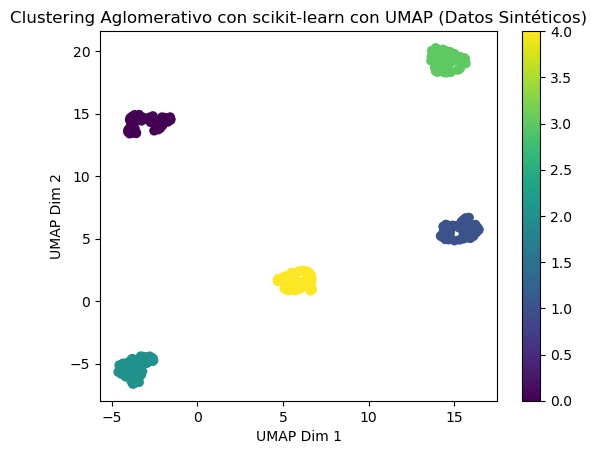

In [29]:
from sklearn.datasets import make_blobs


X, _ = make_blobs(n_samples=300, centers=5, cluster_std=0.60, random_state=0)

# Aplicar UMAP
umap_reducer = umap.UMAP(n_components=2)
umap_data = umap_reducer.fit_transform(X)

# Clustering jerárquico aglomerativo con scikit-learn
agg_clustering_sklearn = AgglomerativeClustering(n_clusters=5)
labels_sklearn = agg_clustering_sklearn.fit_predict(umap_data)

# Visualizar los resultados
plt.scatter(umap_data[:, 0], umap_data[:, 1], c=labels_sklearn, cmap='viridis')
plt.title('Clustering Aglomerativo con scikit-learn con UMAP (Datos Sintéticos)')
plt.xlabel('UMAP Dim 1')
plt.ylabel('UMAP Dim 2')
plt.colorbar()
plt.show()